# 設備の残存耐用時間(RUL)を予測する時系列モデリング
Azure Machine Learning のスケーラブルな計算環境 Machine Learning Compute を用いて、LSTM のモデル開発を行います。設備の残存耐用時間 Remaining Useful Lifetime (RUL) を予測する時系列モデルです。

## 故障予測のアプローチ方法

故障予測のアプローチ方法は色々ありますが、代表的なアプローチを下記に記載しました。本Notebookでは、設備の残存耐用時間(RUL)を予測する深層学習モデルを構築するアプローチを採用しています。

<img src="../../docs/images/RUL.png" align="left" width=550>

## 使用するデータ

<img src="../../docs/images/PowerBI-RUL.png" align="left" width=550>

## Azure ML Workspaceへ接続
Azure Machine Learning service ワークスペースへ接続します。

In [1]:
from azureml.core import Workspace, Experiment
import pandas as pd

ws = Workspace.from_config()

## 実験名の指定

In [2]:
experiment_name = 'hyperdrive-lstm-RUL'

experiment = Experiment(ws, experiment_name)

output = {}
output['SDK version'] = azureml.core.VERSION
output['Subscription ID'] = ws.subscription_id
output['Workspace'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Run History Name'] = experiment_name
pd.set_option('display.max_colwidth', -1)
outputDf = pd.DataFrame(data = output, index = [''])
outputDf.T

,
SDK version,1.0.72
Subscription ID,9c0f91b8-eb2f-484c-979c-15848c098a6b
Workspace,azureml
Resource Group,uksouth
Location,uksouth
Run History Name,hyperdrive-lstm-RUL


## クラウドにデータをアップロード
学習で使用するデータをオンプレミスからクラウドにアップロードします

In [3]:
ds = ws.get_default_datastore()
ds.upload(src_dir='./data', target_path='pm_data', overwrite=False, show_progress=True)

Uploading an estimated of 2 files
Target already exists. Skipping upload for pm_data/test.csv
Target already exists. Skipping upload for pm_data/train.csv
Uploaded 0 files


$AZUREML_DATAREFERENCE_c160538861084f89bf57dcc5b3de08c6

In [4]:
from azureml.core.dataset import Dataset

In [5]:
%%time
train = Dataset.Tabular.from_delimited_files(path = [(ds, 'pm_data/train.csv')])

CPU times: user 645 ms, sys: 111 ms, total: 756 ms
Wall time: 5.98 s


In [6]:
%%time
test = Dataset.Tabular.from_delimited_files(path = [(ds, 'pm_data/test.csv')])

CPU times: user 95.5 ms, sys: 264 µs, total: 95.7 ms
Wall time: 595 ms


In [7]:
train = train.register(workspace = ws,
                           name = 'pm_train',
                           description='predictive maintenance train dataset',
                           create_new_version=True)

In [8]:
test = test.register(workspace = ws,
                           name = 'pm_test',
                           description='predictive maintenance test dataset',
                           create_new_version=True)

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

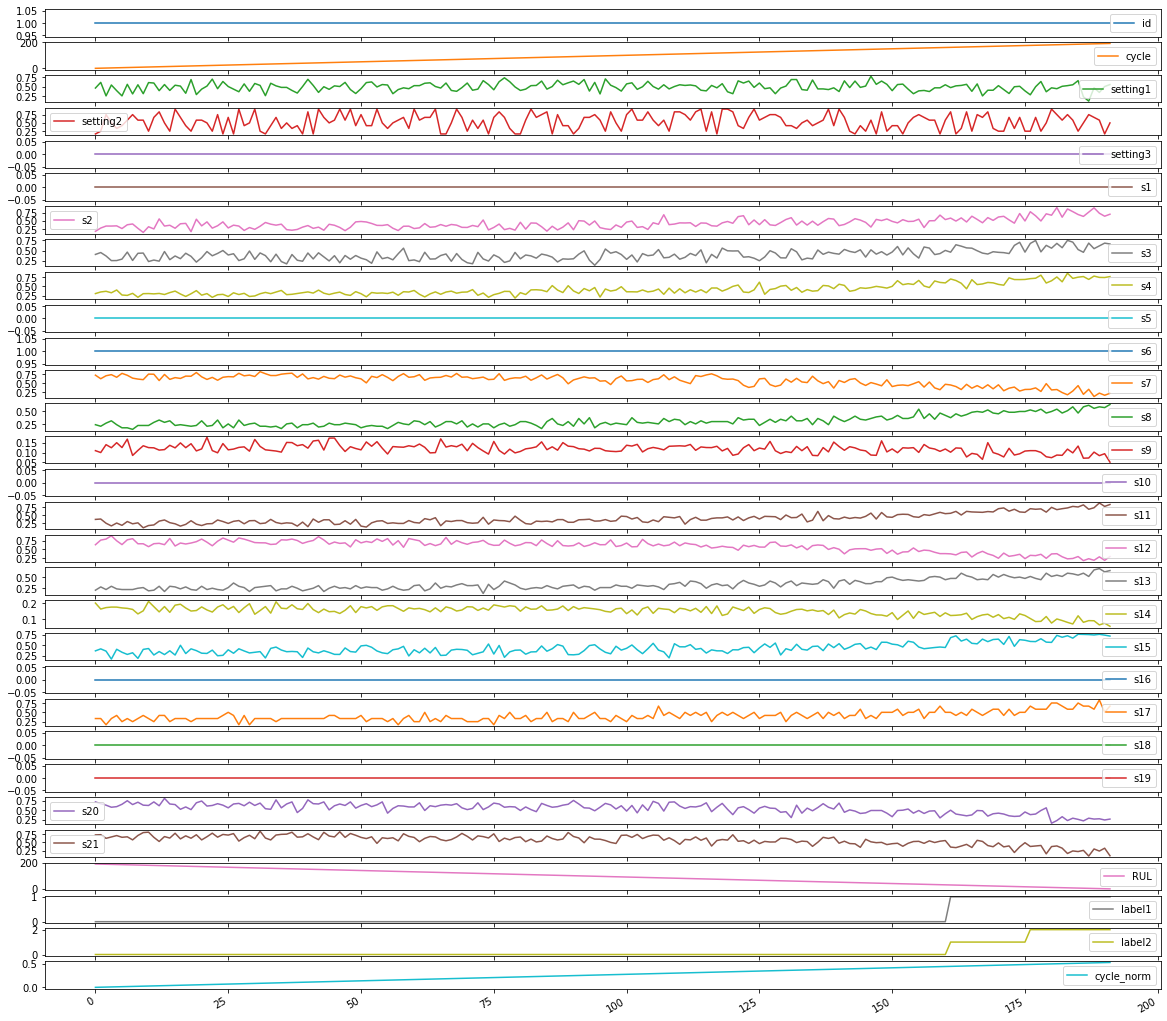

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

train_df = train.to_pandas_dataframe()
plt.clf()
plt.figure()
train_df[train_df["id"]==1].plot(subplots=True, sharex=True, figsize=(20,20))
#plt.savefig(img_path+"turbine1-line.png")
plt.show()

## 学習スクリプト準備

In [11]:
import os
project_folder = "./keras-lstm"
os.makedirs(project_folder, exist_ok=True)

In [12]:
train_df = Dataset.get_by_name(ws,name="pm_train").to_pandas_dataframe()
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s16,s17,s18,s19,s20,s21,RUL,label1,label2,cycle_norm
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0,0,0.00000
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0,0,0.00277
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0,0,0.00554
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0,0,0.00831
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0,0,0.01108


In [13]:
%%writefile {project_folder}/keras_lstm.py

import tensorflow as tf

from tensorflow.python.keras.layers import Conv2D, MaxPooling2D
from tensorflow.python.keras.layers import Activation, Dropout, Flatten, Input, Dense, Dropout, LSTM
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.utils import plot_model
from tensorflow.keras.callbacks import Callback


import os
import pandas as pd
import numpy as np

from azureml.core import Run
from azureml.core import Workspace, Dataset
from keras.utils import plot_model
import argparse


#from keras import initializers, regularizers, constraints, optimizers, layers, callbacks

np.random.seed(1234)  
PYTHONHASHSEED = 0

from azureml.core import Run
run = Run.get_context()

print(dir(run))

parser = argparse.ArgumentParser(description='keras lstm example:')
parser.add_argument('--epochs', '-e', type=int, default=5, help='Number of sweeps over the dataset to train')
parser.add_argument('--batchsize', '-b', type=int, default=32, help='Number of images in each mini-batch')
#parser.add_argument('--dataset', '-d', dest='data_folder',help='The datastore')
args = parser.parse_args()

workspace = run.experiment.workspace

print(workspace.name)

#train_df = pd.read_csv(args.data_folder+"/data/train.csv", sep=",", header=0)
train_df = Dataset.get_by_name(workspace,name="pm_train").to_pandas_dataframe()
train_df['RUL'] = train_df['RUL'].astype(float)

#test_df = pd.read_csv(args.data_folder+"/data/test.csv", sep=",", header=0)
test_df = Dataset.get_by_name(workspace, name="pm_test").to_pandas_dataframe()
test_df['RUL'] = test_df['RUL'].astype(float)

sequence_length = 50

def gen_sequence(id_df, seq_length, seq_cols):
    #指定された列の値を取得
    data_array = id_df[seq_cols].values
    #num_elements : 特定idのデータ数 (for id = 1, it is 192)
    num_elements = data_array.shape[0]
    # for id = 1, zip from both range(0, 142) & range(50, 192)
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        #print(start,stop)
        yield data_array[start:stop, :]
        
        
#  特徴量となる列の抽出 
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

# 学習データのsequences作成
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) for id in train_df['id'].unique())
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)

# function to generate labels
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]

# generate labels
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['label1']) 
             for id in train_df['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)



epochs=args.epochs
batch_size=args.batchsize
validation_split=0.05


# ハイパーパラメータ
run.log("エポック数",epochs)
run.log("バッチサイズ",batch_size)
run.log("検証データ分割",validation_split)


class RunCallback(tf.keras.callbacks.Callback):
    def __init__(self, run):
        self.run = run
        
    def on_epoch_end(self, batch, logs={}):
        print("test")
        self.run.log(name="training_loss", value=float(logs.get('loss')))
        self.run.log(name="validation_loss", value=float(logs.get('val_loss')))
        self.run.log(name="training_acc", value=float(logs.get('acc')))
        self.run.log(name="validation_acc", value=float(logs.get('val_acc')))

callbacks = list()
callbacks.append(RunCallback(run))

# モデルネットワークの定義
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]
print("nb_features:",seq_array.shape[2])
print("nb_out:",label_array.shape[1])

model = Sequential()

model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=nb_out, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

model.fit(x = seq_array, y = label_array, epochs=epochs, batch_size=batch_size, validation_split=validation_split, verbose=1,
          callbacks = callbacks)



# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
run.log("損失",scores[0])
run.log("モデル精度", scores[1])

os.makedirs('./outputs/model', exist_ok=True)
model.save_weights('./outputs/mnist_mlp_weights.h5')

Overwriting ./keras-lstm/keras_lstm.py


## Machine Learning Compute設定

Machine Learning Computeの設定を行います。GPUの場合は**gpucluster**、CPUの場合は**cpucluster**を指定します。

In [14]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException
compute_target = ComputeTarget(ws,"gpucluster")
#compute_target = ComputeTarget(ws,"cpucluster")

## モデル学習設定

TensorFlowのEstimatorの設定を行います。今回は Keras を利用するんで、`pip_packages`に keras を追加します。

In [15]:
from azureml.train.dnn import TensorFlow
from azureml.train.estimator import Estimator



estimator = TensorFlow(source_directory=project_folder,
                       compute_target=compute_target,
                       entry_script='keras_lstm.py',
                       framework_version = '1.13',
                       pip_packages = ['keras',"azureml-dataprep[fuse,pandas]"],
                      )

### 実行開始

上記で定義した TensorFlow Estimator の設定に従って、トレーニング環境を構築し、モデル学習を始めます。

In [16]:
run = experiment.submit(estimator)
print(run)

Run(Experiment: hyperdrive-lstm-RUL,
Id: hyperdrive-lstm-RUL_1573279390_b8231497,
Type: azureml.scriptrun,
Status: Starting)


In [18]:
from azureml.widgets import RunDetails
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

モデル無事完了したことを確認して、次に進みます。

## モデル登録

In [19]:
# run で記録されたファイル一覧
run.get_file_names()

['azureml-logs/55_azureml-execution-tvmps_653d3f188ba55bef7733c47e3aea889404b477eca5175127b684036aee77f172_d.txt',
 'azureml-logs/65_job_prep-tvmps_653d3f188ba55bef7733c47e3aea889404b477eca5175127b684036aee77f172_d.txt',
 'azureml-logs/70_driver_log.txt',
 'azureml-logs/75_job_post-tvmps_653d3f188ba55bef7733c47e3aea889404b477eca5175127b684036aee77f172_d.txt',
 'azureml-logs/process_info.json',
 'azureml-logs/process_status.json',
 'logs/azureml/154_azureml.log',
 'logs/azureml/azureml.log',
 'outputs/mnist_mlp_weights.h5']

In [ ]:
# register the best model with the input dataset
model = run.register_model(model_name='train-with-dataset-model1', model_path="outputs/mnist_mlp_weights.h5",
                           datasets =[('training data',Dataset.get_by_name(ws,name="pm_train"))])

In [ ]:
# register the best model with the input dataset
model = run.register_model(model_name='test', model_path="outputs/mnist_mlp_weights.h5",
                           datasets =[('training data',dataset)])

In [20]:
# model_name : モデル名
# model_path : ファイルパス (run.get_file_names()を参照)
# datasets : 関連するデータセット (トレーサビリティ)
# tag : タグ情報付与

model = run.register_model(model_name = 'RUL-lstm-keras', 
                           model_path = 'outputs/mnist_mlp_weights.h5',
                           datasets =[('train data', train)],
                           tags = {'area': "turbine predictive maintenance", 'type': "lstm"})
print(model.name, model.id, model.version, sep = '\t')

RUL-lstm-keras	RUL-lstm-keras:2	2


In [23]:
# run の詳細情報
#run.get_details()

In [22]:
# Azure Machine Learning Studio でメトリックの確認
run

Experiment,Id,Type,Status,Details Page,Docs Page
hyperdrive-lstm-RUL,hyperdrive-lstm-RUL_1573279390_b8231497,azureml.scriptrun,Completed,Link to Azure Machine Learning studio,Link to Documentation


# ハイパーパラメータチューニング  Hyperdrive

Machine Learning Compute を用いて複数サーバでパラメータチューニングを分散で実行します。今回は Random Search を用います。

In [24]:
from azureml.train.hyperdrive.runconfig import HyperDriveConfig
from azureml.train.hyperdrive.sampling import RandomParameterSampling
from azureml.train.hyperdrive.policy import BanditPolicy
from azureml.train.hyperdrive.run import PrimaryMetricGoal
from azureml.train.hyperdrive.parameter_expressions import choice
    

# ハイパーパラメータの探索空間の定義
param_sampling = RandomParameterSampling( {
    "--batchsize": choice(32, 64, 128, 256),
    "--epochs": choice(5, 10, 20, 40, 80)
    }
)

# 自動パラメータチューニングの設定
# max_total_runs : 試行するパラメータの組み合わせ数
# max_concurrent_runs : 最大並列計算ノード数 (Machine Learning Compute)
hyperdrive_run_config = HyperDriveConfig(estimator=estimator,
                                            hyperparameter_sampling=param_sampling, 
                                            primary_metric_name='validation_acc',
                                            primary_metric_goal=PrimaryMetricGoal.MAXIMIZE,
                                            max_total_runs=4,
                                            max_concurrent_runs=4)

## 実行開始

In [25]:
hyperdrive_run = experiment.submit(hyperdrive_run_config)

In [27]:
from azureml.widgets import RunDetails
RunDetails(hyperdrive_run).show()

_HyperDriveWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO'…